In [4]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [5]:
N = 256
P = 64

ori_img = cv2.imread('./assets/lena.png', 0)

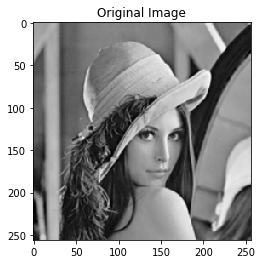

In [6]:
def imshow(imgdata, title=''):
    plt.figure()
    plt.title(title)
    plt.imshow(imgdata, cmap = 'gray')
    plt.show()
    
def imsave(imgdata, filename, title=''):
    plt.figure()
    plt.title(title)
    plt.imshow(imgdata, cmap = 'gray')
    plt.savefig('dist/' + filename+'.png')

imshow(cv2.resize(ori_img, (N,N)), 'Original Image')

In [7]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [8]:
def translateIndex2(index):
    return (2 * index - N + 1) / (N - 1) / np.sqrt(2)

def translateIndex(index):
    return (2 * index - N + 1) / N

In [9]:
def transformPHT(image, size, maxOrder):

    t_len = 2 * maxOrder + 1
    
    resized = cv2.resize(image, (size, size))
    imvec = np.reshape(np.array(resized), (size * size, 1))
    del resized
    
    transformed = np.array([])
    
    global T_STEP
    try:
        T_STEP
    except NameError:
        T_STEP =  int(maxOrder / 6) + 1

    # GENERATE MATRIX TRANSFORM

    vecN = np.ones((t_len, t_len), dtype='float32')
    vecM = np.ones((t_len, t_len), dtype='float32')
    for i in range(-maxOrder, maxOrder+1):
        vecN[i + maxOrder, :] = i
        vecM[:, i + maxOrder] = i
    vecN = vecN.reshape((t_len * t_len, 1))
    vecM = vecM.reshape((t_len * t_len, 1))

    vecI = np.ones((size, size), dtype='float32')
    vecK = np.ones((size, size), dtype='float32')
    for i in range(size):
        vecI[i,:] = i
        vecK[:,i] = i
    vecI = vecI.reshape((1, size * size))
    vecK = vecK.reshape((1, size * size))

    vecY = translateIndex(vecI)
    vecX = translateIndex(vecK)
    vecR = np.sqrt(vecX * vecX + vecY * vecY)
    vecT = np.arctan2(vecY, vecX)

    # FREE UP SOME MEMORY - 1
    del vecI
    del vecK
    del vecY
    del vecX

    update_progress(0)
    for row in range(int(np.ceil(t_len / T_STEP))):
        start = row * T_STEP * t_len
        end = np.min([row * T_STEP + T_STEP, t_len]) * t_len
        matR = np.repeat(vecR, end - start, axis=0)
        matT = np.repeat(vecT, end - start, axis=0)
        matN = np.repeat(vecN[start:end, :], size * size, axis=1)
        matM = np.repeat(vecM[start:end, :], size * size, axis=1)
        matC = (matR <= 1)

        matW = matC * 2 / (np.pi * size * size) * np.exp(-2 * np.pi * matN * matR * matR * 1j - matM * matT * 1j)
        trf_row = np.matmul(matW, imvec)
        transformed = np.append(transformed, trf_row)

        # FREE UP SOME MEMORY - 2
        del matW
        del matN
        del matM
        del matR
        del matT
        del matC

        update_progress((row * T_STEP + T_STEP) / t_len)

    update_progress(1)
    
    transformed2 = np.reshape(transformed, (t_len, t_len))
    del transformed
    return transformed2

In [10]:
def inversPHT(momen, size, maxOrder):
    
    t_len = 2 * maxOrder + 1

    momenvec = np.reshape(np.array(momen), (t_len * t_len, 1))
    inversed = np.array([])
    
    global I_STEP
    try:
        I_STEP
    except NameError:
        I_STEP =  int(size / 6) + 1


    # GENERATE MATRIX INVERS TRANSFORM

    vecN = np.ones((t_len, t_len), dtype='float32')
    vecM = np.ones((t_len, t_len), dtype='float32')
    for i in range(-maxOrder, maxOrder+1):
        vecN[i + maxOrder, :] = i
        vecM[:, i + maxOrder] = i
    vecN = vecN.reshape((1, t_len * t_len))
    vecM = vecM.reshape((1, t_len * t_len))

    vecI = np.ones((size, size), dtype='float32')
    vecK = np.ones((size, size), dtype='float32')
    for i in range(size):
        vecI[i,:] = i
        vecK[:,i] = i
    vecI = vecI.reshape((size * size, 1))
    vecK = vecK.reshape((size * size, 1))

    vecY = translateIndex(vecI)
    vecX = translateIndex(vecK)
    vecR = np.sqrt(vecX * vecX + vecY * vecY)
    vecT = np.arctan2(vecY, vecX)

    # FREE UP SOME MEMORY - 1
    del vecI
    del vecK
    del vecY
    del vecX

    update_progress(0)
    for row in range(int(np.ceil(size / I_STEP))):
        start = row * I_STEP * size
        end = np.min([row * I_STEP + I_STEP, size]) * size
        matR = np.repeat(vecR[start:end, :], t_len * t_len, axis=1)
        matT = np.repeat(vecT[start:end, :], t_len * t_len, axis=1)
        matN = np.repeat(vecN, end - start, axis=0)
        matM = np.repeat(vecM, end - start, axis=0)
        matC = (matR <= 1)

        matV = matC * np.exp(2 * np.pi * matN * matR * matR * 1j + matM * matT * 1j)
        inv_row = np.matmul(matV, momenvec)
        inversed = np.append(inversed, inv_row)

        # FREE UP SOME MEMORY - 2
        del matV
        del matN
        del matM
        del matR
        del matT
        del matC

        update_progress((row * I_STEP + I_STEP) / size)

    update_progress(1)
    
    inversed2 = np.reshape(inversed, (size, size))
    del inversed
    return inversed2

Progress: [####################] 100.0%


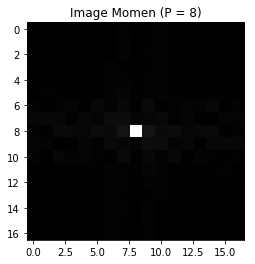

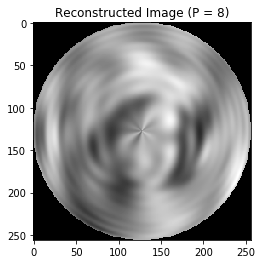

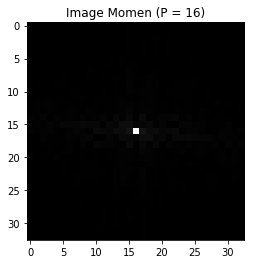

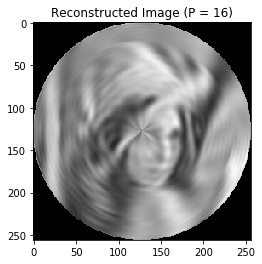

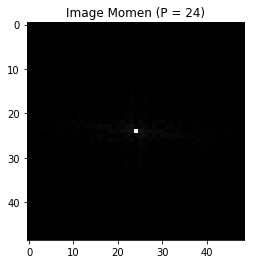

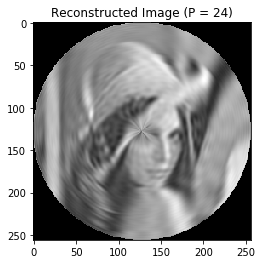

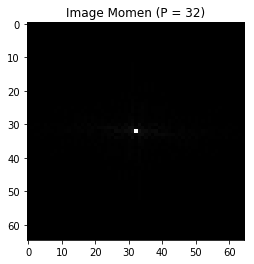

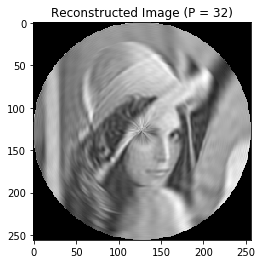

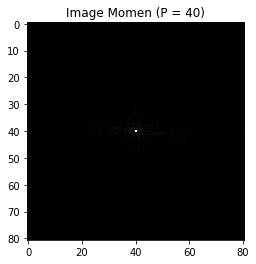

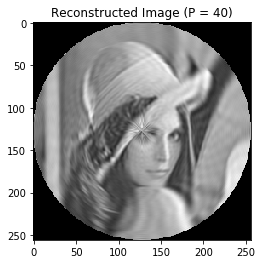

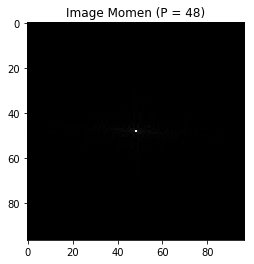

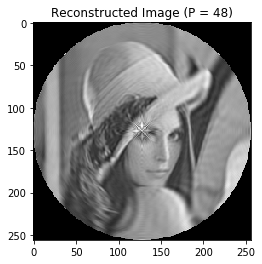

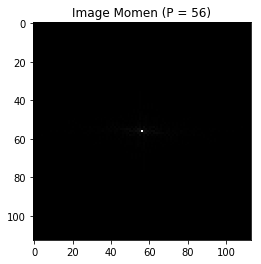

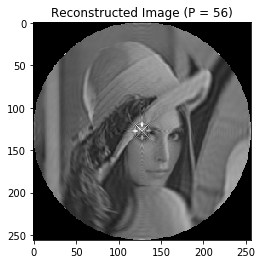

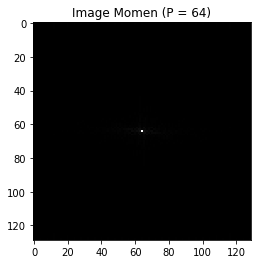

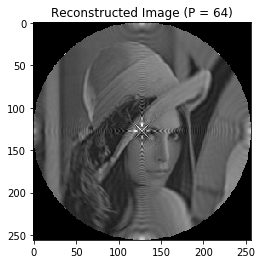

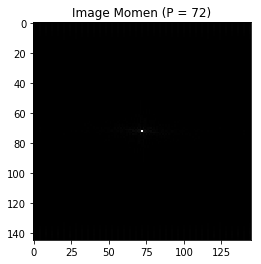

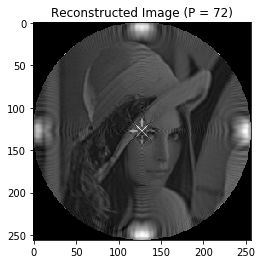

In [11]:
for i in range(8, 73, 8):
    print('P = ' + str(i))
    
    transformed = transformPHT(ori_img, N, i)
    transformed_abs = np.abs(transformed)
#     imshow(transformed_abs, 'Image Momen (P = ' + str(i) + ')')
    imsave(transformed_abs, 'momen_' + str(i), 'Image Momen (P = ' + str(i) + ')')
    
    inversed = inversPHT(transformed, N, i)
    inversed_abs = np.abs(inversed)
#     imshow(inversed_abs, 'Reconstructed Image (P = ' + str(i) + ')')
    imsave(inversed_abs, 'inversed_' + str(i), 'Reconstructed Image (P = ' + str(i) + ')')
    
    del transformed
    del transformed_abs
    del inversed
    del inversed_abs